![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-01.jpg)
![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-07.jpg)


## Introduction to the Drunkard's Walk and Markov Models

The **drunkard's walk** is a classic example of a random process, often used to illustrate the concept of stochastic movement. Imagine a person (the "drunkard") standing on a street who, at each step, randomly chooses to move either left or right. Over time, the path traced by the drunkard forms a sequence of positions that depend only on the previous position and the random choice made at each step.

This process is a simple yet powerful illustration of a **Markov model**. In a Markov model, the future state of a system depends only on its current state, not on the sequence of events that preceded it. The drunkard's walk embodies this property: each new position is determined solely by the current position and a random decision, making it a **Markov process**.

Markov models are widely used in fields such as physics, finance, biology, and computer science to model systems that evolve over time with probabilistic transitions. The drunkard's walk provides an intuitive foundation for understanding these models and their applications.

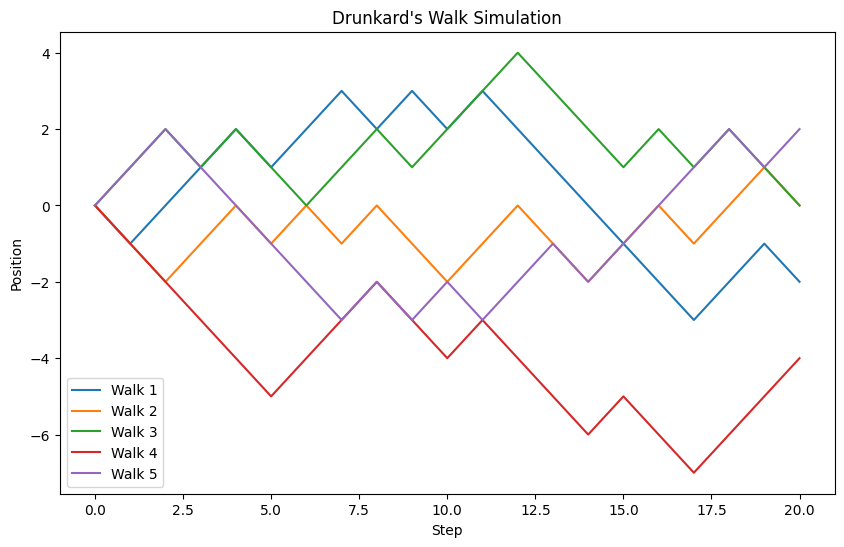

In [7]:
import numpy as np

import matplotlib.pyplot as plt

def drunkards_walk(steps, start=0):
    # Flip a coin: 1 for right, -1 for left
    moves = np.random.choice([-1, 1], size=steps)
    positions = np.cumsum(np.insert(moves, 0, start))
    return positions

num_walks = 5
steps = 20

plt.figure(figsize=(10, 6))
for i in range(num_walks):
    walk = drunkards_walk(steps)
    plt.plot(walk, label=f'Walk {i+1}')
plt.xlabel('Step')
plt.ylabel('Position')
plt.title('Drunkard\'s Walk Simulation')
plt.legend()
plt.show()

## Stochastic Nature of the Drunkard's Walk

When we simulate the drunkard's walk multiple times, each walk consists of 20 steps where the direction at each step is chosen randomly. This randomness means that every trial can produce a different sequence of moves, leading the drunkard to end up in different positions after 20 steps.

This variability in outcomes is a hallmark of **stochastic processes**—systems that evolve with inherent randomness. Even though the rules for each step are the same, the random choices made at each step cause the final position to vary from trial to trial. By plotting several walks, we can visually see how the drunkard's path diverges, illustrating the unpredictable nature of stochastic systems like Markov models.

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-08.jpg)

## Introduction to the Markov Babbler

A **Markov babbler** is a simple text-generating model that uses the principles of Markov processes to produce sequences of words or characters. The core idea is that the next word (or character) in the sequence depends only on the current state—typically the previous word or a short context—rather than the entire history of the sequence.

Markov babblers are often used to create amusing or surprisingly coherent text by analyzing a source document and learning the probabilities of transitions between words or characters. When generating new text, the babbler randomly selects the next word based on these learned probabilities, resulting in output that mimics the style and structure of the original source, but with unpredictable and sometimes nonsensical results.

This approach illustrates the power and limitations of Markov models in language generation: while they can capture local patterns and produce plausible short phrases, they lack the deeper understanding needed for truly meaningful or context-aware text. Nonetheless, Markov babblers provide an accessible and entertaining way to explore stochastic processes and probabilistic modeling in natural language.

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-09.jpg)
![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-10.jpg)

## The Training Set for a Markov Babbler

To build a Markov babbler, we first need a **training set**—a collection of text that serves as the source material for learning transition probabilities. The training set can be anything from a single paragraph to an entire book, depending on the desired complexity and style of the generated output.

The Markov babbler analyzes the training set to determine how often each word (or character) follows another. By recording these transitions, the model builds a probabilistic map of the text's structure. When generating new text, the babbler uses this map to randomly select the next word based on the current context, mimicking the patterns found in the training set.

A well-chosen training set helps the Markov babbler produce output that reflects the vocabulary, style, and quirks of the original text, making the generated sequences both recognizable and entertaining.

In [8]:
training_data = """
"Jabberwocky"
by Lewis Carroll

'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe;
All mimsy were the borogoves,
And the mome raths outgrabe.

"Beware the Jabberwock, my son!
The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
The frumious Bandersnatch!"

He took his vorpal sword in hand:
Long time the manxome foe he sought—
So rested he by the Tumtum tree,
And stood awhile in thought.

And as in uffish thought he stood,
The Jabberwock, with eyes of flame,
Came whiffling through the tulgey wood,
And burbled as it came!

One, two! One, two! And through and through
The vorpal blade went snicker-snack!
He left it dead, and with its head
He went galumphing back.

"And hast thou slain the Jabberwock?
Come to my arms, my beamish boy!
O frabjous day! Callooh! Callay!"
He chortled in his joy.

'Twas brillig, and the slithy toves
Did gyre and gimble in the wabe;
All mimsy were the borogoves,
And the mome raths outgrabe. 
"""

In [ ]:
# Markov babbler: order-k Markov chain over tokens
# Builds a conditional frequency table from training sequences and then
# samples the next token conditioned on the most recent k tokens.
"""A stationary source.

Produces random sequences of item based on an initial collection of data.
"""
from collections import defaultdict, deque, Counter
import random

# Data structures used:
# - defaultdict(Counter): maps a context (tuple of last k tokens) -> counts of next tokens
# - deque: fixed-length sliding window to track the last k tokens (the "state")
#
# Note: We use None as a sentinel to represent "no token yet" when padding the
#       initial context up to length k. Input collections must not contain None.

__version__ = "0.1.0"

class StationarySource(object):
    """A stationary source object.

    Produces random sequences of item based on an initial collection
    of data.

    collections must not contain any None's. They are reserved for interal
    signaling.
    """
    def __init__(self, collections, order):
        # order (k): how many previous tokens constitute the context/state
        self._order = order

        # Frequency table: context -> Counter(next_token -> count)
        self._table = defaultdict(Counter)
        # Merge conditional counts from each training sequence (collection).
        for collection in collections:
            t = self._analyze_collection(collection)
            for key in t:
                self._table[key].update(t[key])

    @property
    def order(self):
        """The Markov order k (context length)."""
        return self._order

    def _source(self):
        """Construct the initial context deque padded with None.

        Returns a fixed-length deque of size k that will always keep
        only the last k tokens as we append during analysis/generation.
        """
        return deque([None] * self.order, maxlen=self.order)

    def _analyze_collection(self, collection):
        """Analyze one training sequence and collect conditional counts.

        We slide a k-length window (the context) over the sequence. For each
        next token, we increment count[context][token]. The context is stored
        as a tuple so it is hashable for dict keys.
        """
        table = defaultdict(Counter)
        q = self._source()
        for item in collection:
            # Users must not include None in training data; None is our sentinel.
            assert item is not None, "Collections cannot contain None's."
            # Record that from this context, we observed 'item' next.
            table[tuple(q)][item] += 1
            # Slide the window: drop oldest if at capacity, append new item.
            q.append(item)
        return table

    def _weighted_choice(self, item_weights):
        """Choose a random item from a weighted list of (item, count).

        This uses a single pass "reservoir"-like method: for each candidate
        with weight w, we pick it with probability w / (sum so far + w).
        Equivalent to sampling proportional to counts without building a CDF.
        Raises ValueError if item_weights is empty.
        """
        item, weight = (None, 0)
        for item2, weight2 in item_weights:
            n = random.randint(1, weight + weight2)
            if n <= weight2:
                item = item2
            weight = weight + weight2
        if item is None and weight == 0:
            raise ValueError("No items supplied.")
        else:
            return item

    def generate_sequence(self):
        """Generate an infinite-like stream until no transitions exist.

        We begin at the START context (all None). At each step, we sample a
        next token from the context's empirical distribution. If a context
        has no outgoing edges (unseen in training), generation stops.
        """
        key = self._source()
        while True:
            items = self._table[tuple(key)].items()
            try:
                item = self._weighted_choice(items)
            except ValueError:
                # No next items for this context: terminate the stream.
                break
            else:
                yield item
                # Advance the context window with the emitted token.
                key.append(item)

In [19]:
def get_lines():
    for line in training_data.strip().split("\n"):
        yield line.strip().split()

if __name__ == "__main__":
    lines = list(get_lines())
    g = StationarySource(lines, 1)
    for _ in range(10):
        print(" ".join(list(g.generate_sequence())))

The vorpal sword in the mome raths outgrabe.
'Twas brillig, and gimble in thought.
And through the borogoves,
All mimsy were the Jabberwock, with eyes of flame,
'Twas brillig, and the wabe;
So rested he sought—
Came whiffling through the Jabberwock, my son!
"Jabberwocky"
Did gyre and gimble in his vorpal sword in the manxome foe he by the mome raths outgrabe.
Come to my son!


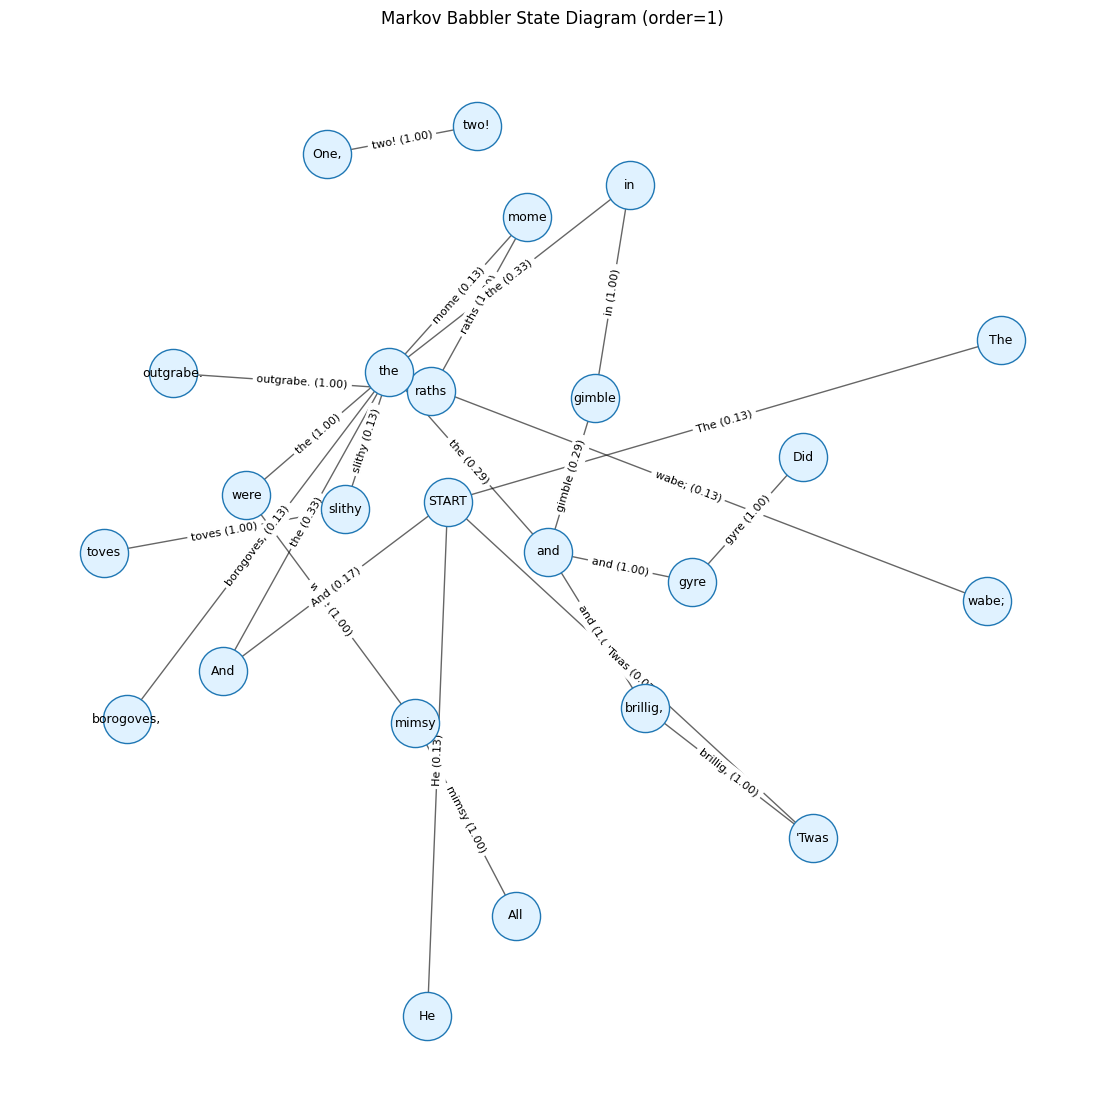

In [ ]:
# Visualize a state diagram for the Markov babbler
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def _format_context(ctx):
    if not ctx:
        return "(∅)"
    if all(x is None for x in ctx):
        return "START"
    return " ".join(str(x) for x in ctx if x is not None)

def build_state_graph(source, top_k_states=20, top_k_edges=2, min_count=2):
    order = source.order
    table = source._table
    # Rank states by total outgoing count
    state_counts = {k: sum(table[k].values()) for k in table}
    states_sorted = sorted(state_counts, key=lambda k: state_counts[k], reverse=True)
    keep_states = set(states_sorted[:top_k_states])

    G = nx.DiGraph()
    for state in keep_states:
        counts = table[state]
        if not counts:
            continue
        total = sum(counts.values())
        # Choose the top edges per state
        items_sorted = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
        kept = 0
        for item, cnt in items_sorted:
            if cnt < min_count:
                continue
            kept += 1
            if kept > top_k_edges:
                break
            # Compute next state by appending the emitted item
            if order > 0:
                q = deque(state, maxlen=order)
                q.append(item)
                next_state = tuple(q)
            else:
                next_state = tuple()
            # Ensure nodes exist and add labeled edge with probability
            G.add_node(_format_context(state))
            G.add_node(_format_context(next_state))
            prob = cnt / total
            G.add_edge(_format_context(state), _format_context(next_state),
                       label=f"{item} ({prob:.2f})", weight=prob)
    return G

# Build the model (order=1 like above) and plot
lines = list(get_lines())
g = StationarySource(lines, 1)
G = build_state_graph(g, top_k_states=40, top_k_edges=3, min_count=1)

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42, k=0.6)
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#E0F2FF", edgecolors="#1f77b4")
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", alpha=0.6)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Markov Babbler State Diagram (order=1)")
plt.axis("off")
plt.show()


## Markov Babbler Text Generation and State Diagram

The Markov babbler implemented above uses an **order-1 Markov chain** to generate text sequences based on the training data from Lewis Carroll's "Jabberwocky." In this model, each word is predicted solely from the previous word, capturing local patterns and transitions found in the source text.

### How Generation Works

- The babbler analyzes the training data and builds a table of transition probabilities between words.
- Starting from a special "START" state, it randomly selects the next word according to the learned probabilities.
- This process continues, with each new word chosen based only on the current state (the previous word), until no further transitions are available.

This approach produces text that mimics the style and vocabulary of the original poem, but the output is stochastic and can be surprising or nonsensical, reflecting the limitations of short-context Markov models.

### State Diagram Visualization

The **state diagram** visualizes the Markov chain as a directed graph:
- **Nodes** represent states (contexts), which in this case are individual words or the "START" state.
- **Edges** show possible transitions between states, labeled with the next word and its transition probability.
- The diagram helps illustrate which words are most likely to follow each other and highlights the structure and flow of the generated text.

By examining the state diagram, you can see the most common transitions and how the babbler navigates through the vocabulary of the training set, providing insight into the underlying stochastic process.

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-11.jpg)

## N-grams and Markov Babblers

In the context of Markov babblers, **n-grams** are contiguous sequences of `n` items (typically words or characters) from a given text. The concept of n-grams is closely related to the order of a Markov model:

- An **order-1 Markov babbler** uses 1-grams (unigrams), where the next word is predicted based only on the previous single word.
- An **order-2 Markov babbler** uses 2-grams (bigrams), predicting the next word based on the previous two words.
- Higher-order Markov babblers use longer n-grams, considering more context for each prediction.

The Markov babbler builds a probabilistic model by analyzing the frequency of n-grams in the training data. When generating text, it uses the most recent `n-1` words as context to select the next word, mimicking the local patterns found in the source material.

**Advantages of n-grams in Markov babblers:**
- Captures local structure and style from the training text.
- Higher-order n-grams can produce more coherent and contextually relevant sequences.

**Limitations:**
- Markov babblers with small n (low order) may generate nonsensical or repetitive text due to limited context.
- Very large n-grams require more training data and can overfit, reducing the diversity of generated output.

In summary, n-grams are the foundation for context and prediction in Markov babblers, balancing between randomness and coherence depending on the chosen order.

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-12.jpg)

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-13.jpg)

## Introduction to Hidden Markov Models (HMMs) and Their Role in AI

A **Hidden Markov Model (HMM)** is a powerful statistical model used to describe systems that evolve over time with underlying hidden states. Unlike simple Markov models, where the current state is directly observable, HMMs assume that the true state of the system is hidden and can only be inferred through observable outputs (emissions).

### How HMMs Work

- **States:** The system transitions between a set of hidden states according to certain probabilities.
- **Observations:** At each step, the system emits an observable output, which depends probabilistically on the current hidden state.
- **Inference:** The challenge is to infer the most likely sequence of hidden states given a sequence of observations.

HMMs are widely used in fields such as speech recognition, bioinformatics, natural language processing, and finance, where the underlying process is not directly visible but can be inferred from data.

### Why HMMs Are Considered AI

Hidden Markov Models are considered a form of **artificial intelligence** because they enable machines to learn, reason, and make predictions about complex, uncertain systems. HMMs can:

- **Model uncertainty:** Handle situations where information is incomplete or noisy.
- **Learn patterns:** Discover hidden structure in sequential data.
- **Make intelligent decisions:** Infer the most probable explanations or predict future events based on observed evidence.

By combining probabilistic reasoning with learning from data, HMMs allow computers to perform tasks that require understanding and interpreting hidden processes—an essential aspect of intelligent behavior.

## Key Components of a Hidden Markov Model (HMM)

A Hidden Markov Model consists of several fundamental pieces:

1. **Hidden States**
    - These represent the underlying, unobservable conditions of the system.
    - Example: In speech recognition, hidden states might be phonemes.

2. **Observations (Emissions)**
    - These are the visible outputs generated by the system at each time step.
    - Example: In speech recognition, observations could be audio features.

3. **Transition Probabilities**
    - The probability of moving from one hidden state to another.
    - Represented as a matrix where each entry specifies the likelihood of transitioning between states.

4. **Emission Probabilities**
    - The probability of observing a particular output given the current hidden state.
    - Defines how likely each observation is for each state.

5. **Initial State Probabilities**
    - The probability distribution over which state the system starts in.

### Summary Table

| Piece                  | Description                                      |
|------------------------|--------------------------------------------------|
| Hidden States          | Unobservable system conditions                   |
| Observations           | Visible outputs at each time step                |
| Transition Probabilities | Likelihood of moving between hidden states     |
| Emission Probabilities | Likelihood of each observation per state         |
| Initial State Probabilities | Starting state distribution                 |

These components work together to model sequences where the true state is hidden but can be inferred from observed data.

![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-14.jpg)
![Slide 1 - Decision Trees Title](../img/lecture07_markov_models/slide-15.jpg)

## Inference in Hidden Markov Models and the Viterbi Algorithm

In a **Hidden Markov Model (HMM)**, the true sequence of hidden states is not directly observable. Instead, we only see a sequence of observations (emissions) generated by those hidden states. **Inference** in an HMM refers to the process of deducing information about the hidden states based on the observed data.

### The Inference Problem

Given a sequence of observations, common inference tasks include:
- **Decoding:** Finding the most likely sequence of hidden states that could have produced the observations.
- **Evaluation:** Computing the probability of the observed sequence given the model.
- **Learning:** Estimating the model parameters from data.

The **decoding** problem is especially important in applications like speech recognition, bioinformatics, and natural language processing, where we want to reconstruct the hidden state sequence from noisy or ambiguous observations.

### The Viterbi Algorithm

The **Viterbi algorithm** is a dynamic programming technique used to efficiently find the most probable sequence of hidden states (the "Viterbi path") given a sequence of observations and an HMM. It works by recursively computing the highest probability of any path that ends in each possible state at each time step, keeping track of the best paths.

**Key steps of the Viterbi algorithm:**
1. **Initialization:** Set up the starting probabilities for each state.
2. **Recursion:** For each time step and each state, compute the maximum probability of reaching that state from any previous state, considering both transition and emission probabilities.
3. **Termination:** Identify the final state with the highest probability.
4. **Backtracking:** Reconstruct the most likely sequence of hidden states by following the best transitions backward.

The Viterbi algorithm is widely used because it is both efficient and guarantees finding the most likely state sequence for a given
**Summary:**  
 observation sequence under the HMM.## Inference in Hidden Markov Models and the Viterbi Algorithm

In a **Hidden Markov Model (HMM)**, the true sequence of hidden states is not directly observable. Instead, we only see a sequence of observations (emissions) generated by those hidden states. **Inference** in an HMM refers to the process of deducing information about the hidden states based on the observed data.